In [1]:

%pprint
import sys
if (osp.join(os.pardir, 'py') not in sys.path): sys.path.insert(1, osp.join(os.pardir, 'py'))

Pretty printing has been turned OFF


In [2]:

from FRVRS import (nu, fu, DataFrame, display)
import os
import humanize

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(832366, 109)



# Number of Patients Treated

In [4]:

# Number of patients treated
if nu.pickle_exists('percentage_treated_df'):
    percentage_treated_df = nu.load_object('percentage_treated_df')
else:
    
    # Initialize an empty list to store data for each session group
    rows_list = []
    
    # Iterate over the grouped dataframe
    for (session_uuid, scene_id), scene_df in frvrs_logs_df.groupby(fu.scene_groupby_columns):
    
        # Get the logger version
        logger_version = fu.get_logger_version(scene_df)
    
        # Count the number of unique patients in the current group
        patients_count = fu.get_patient_count(scene_df)
        
        # Initialize a counter for patients treated in the current group
        patients_treated = 0
        
        # Iterate over the patients in the group
        for patient_id, patient_df in scene_df.groupby('patient_id'):
    
            # Create a mask to filter rows where action_type is 'INJURY_TREATED'
            mask_series = (patient_df.action_type == 'INJURY_TREATED')
            
            # Check if any rows satisfy the mask, increment the number of patients treated
            if mask_series.any(): patients_treated += 1
    
        # Check if there are any patients in the current group
        if patients_count:
    
            # Create a dictionary to store information about the current session group
            row_dict = {}
    
            # Add the logger version to the dictionary
            row_dict['logger_version'] = logger_version
    
            # Add the session_uuid and the scene_id to the dictionary
            for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
    
            # Add the number of patients in the group to the dictionary
            row_dict['patients_count'] = patients_count
    
            # Add the number of patients treated to the dictionary
            row_dict['patients_treated'] = patients_treated
    
            # Calculate and add the percentage of patients treated to the dictionary
            row_dict['percentage_treated'] = patients_treated / patients_count
    
            # Add the row dictionary to the list of rows
            rows_list.append(row_dict)
    
    # Create a data frame from the list of rows
    percentage_treated_df = DataFrame(rows_list)
    nu.store_objects(percentage_treated_df=percentage_treated_df)

Pickling to C:\Users\DaveBabbitt\Documents\GitHub\itm-analysis-reporting\saves\pkl\percentage_treated_df.pkl


In [7]:

ave_patients_treated = percentage_treated_df.patients_treated.mean()
print(f'The average number of patients treated per scene is {ave_patients_treated:0.2}.')
percentage_treated_df.sort_values('percentage_treated')

The average number of patients treated per scene is 3.0.


logger_version                          session_uuid  scene_id  \
0               1.3  009b848c-ea64-4f22-bd40-711213a3d327           0   
573             1.0  83b96c70-e156-4c10-b463-800c5a468ec5           0   
575             1.3  84282ed0-0e63-44e0-8b39-5156e3c868d0           0   
578             1.0  845d87c5-7b8b-4bf3-bfc6-91c74e285243           0   
579             1.0  845d87c5-7b8b-4bf3-bfc6-91c74e285243           1   
..              ...                                   ...         ...   
960             1.0  e2458ea2-71b5-4b84-bbfb-dff0a969c9d2           1   
497             1.0  724fdf45-3165-43b8-b9ca-dc07102d2886           2   
108             1.3  1563e213-aaa4-4b79-84a1-8f917ea9f7a9           1   
27              1.0  06574b6f-ab02-432c-9a65-7b031218a270           3   
335             1.3  48e95cfe-1dd7-4085-9662-c77827980bdd           1   

     patients_count  patients_treated  percentage_treated  
0                 1                 0            0.000000  
573               8                 0            0.000000  
575               4                 0            0.000000  
578               9                 0            0.000000  
579              26                 0            0.000000  
..              ...               ...                 ...  
960              12                 8            0.666667  
497              12                 8            0.666667  
108              12                 8            0.666667  
27                5                 4            0.800000  
335               5                 4            0.800000  

[1097 rows x 6 columns]

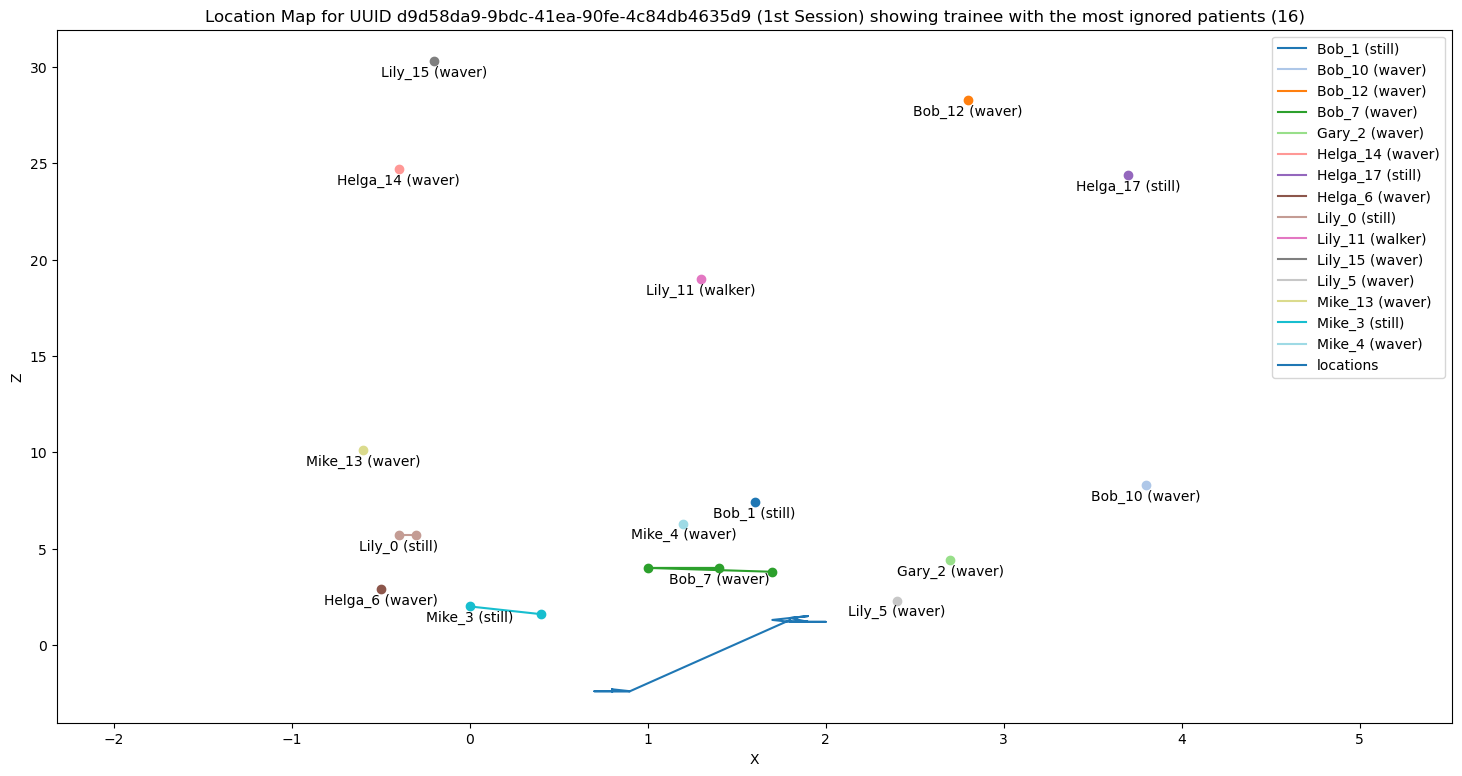

In [10]:

# Get scene with the most ignored patients, v1.3
mask_series = (percentage_treated_df.percentage_treated == 0) & (percentage_treated_df.logger_version == 1.3)
fu.visualize_extreme_player_movement(
    frvrs_logs_df, percentage_treated_df, 'patients_count', mask_series=mask_series, is_ascending=False,
    humanize_type='intword', title_str='most ignored patients', verbose=False
)

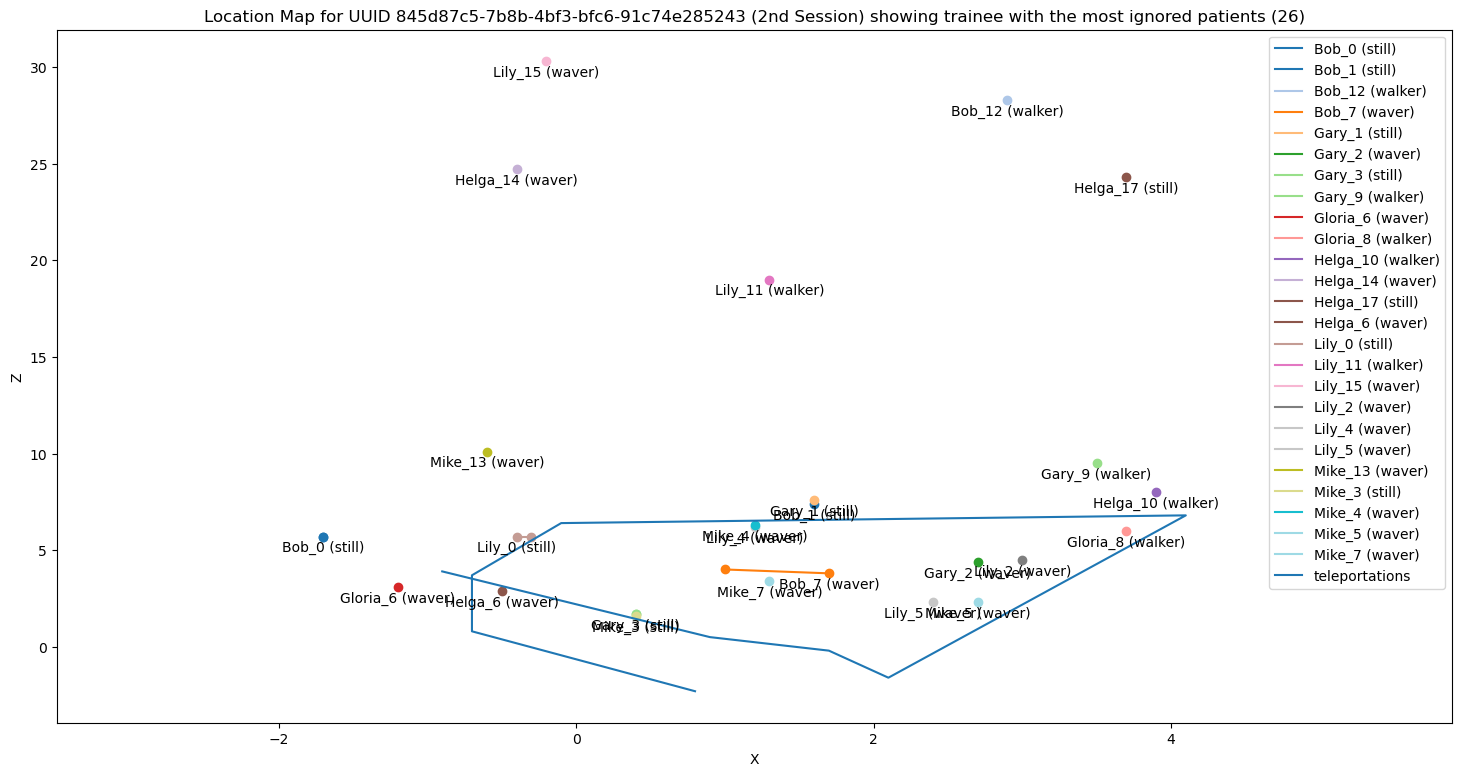

In [9]:

# Get scene with the most ignored patients, v1.0
mask_series = (percentage_treated_df.percentage_treated == 0) & (percentage_treated_df.logger_version == 1.0)
fu.visualize_extreme_player_movement(
    frvrs_logs_df, percentage_treated_df, 'patients_count', mask_series=mask_series, is_ascending=False,
    humanize_type='intword', title_str='most ignored patients', verbose=False
)

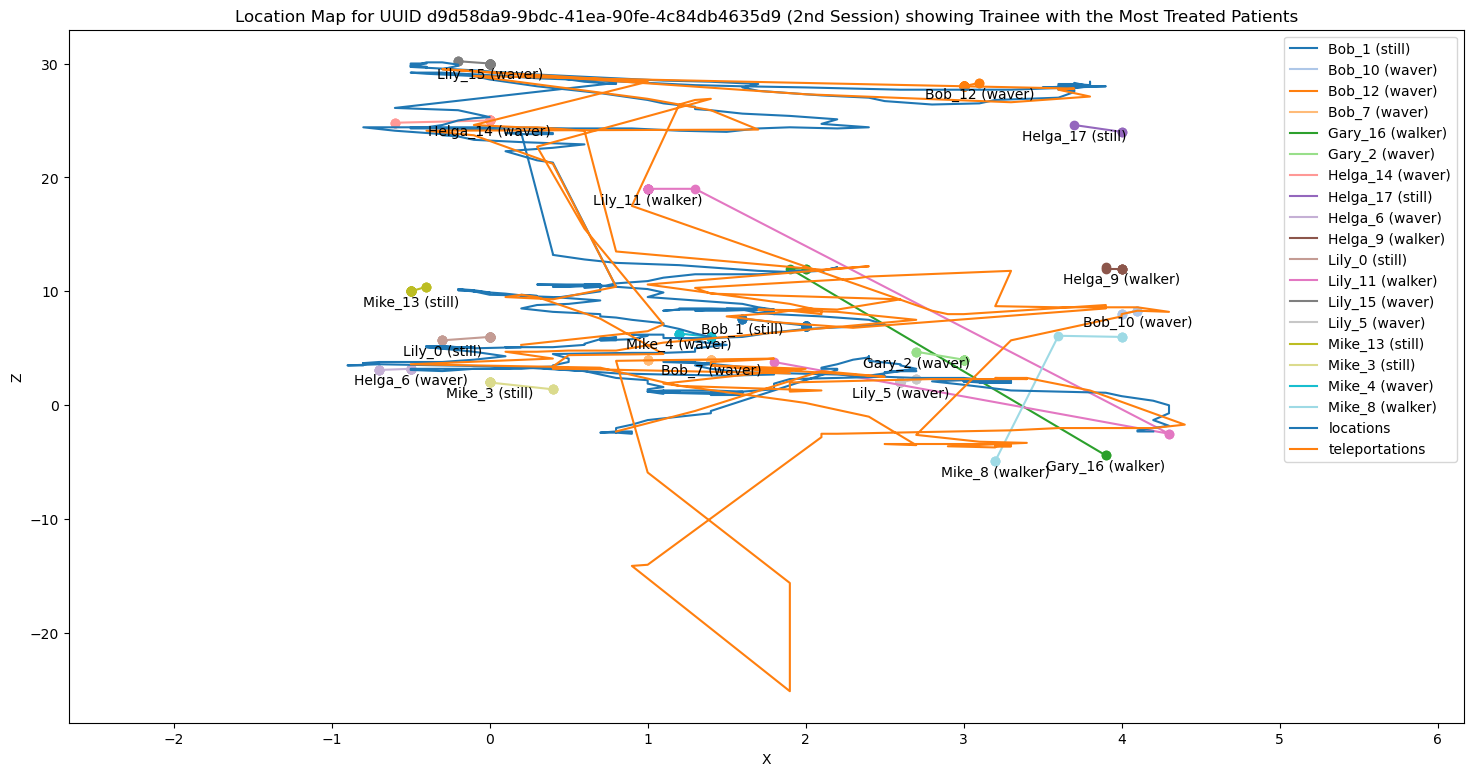

In [12]:

# Get scene with the least ignored patients, v1.3
mask_series = (percentage_treated_df.logger_version == 1.3)
df = percentage_treated_df[mask_series].sort_values(['percentage_treated', 'patients_count']).tail(1)
patients_session_uuid = df.session_uuid.squeeze()
patients_time_group = df.scene_id.squeeze()
base_mask_series = (frvrs_logs_df.session_uuid == patients_session_uuid) & (frvrs_logs_df.scene_id == patients_time_group)

title = f'Location Map for UUID {patients_session_uuid} ({humanize.ordinal(patients_time_group+1)} Session)'
title += ' showing Trainee with the Most Treated Patients'
fu.visualize_player_movement(frvrs_logs_df, base_mask_series, title=title)

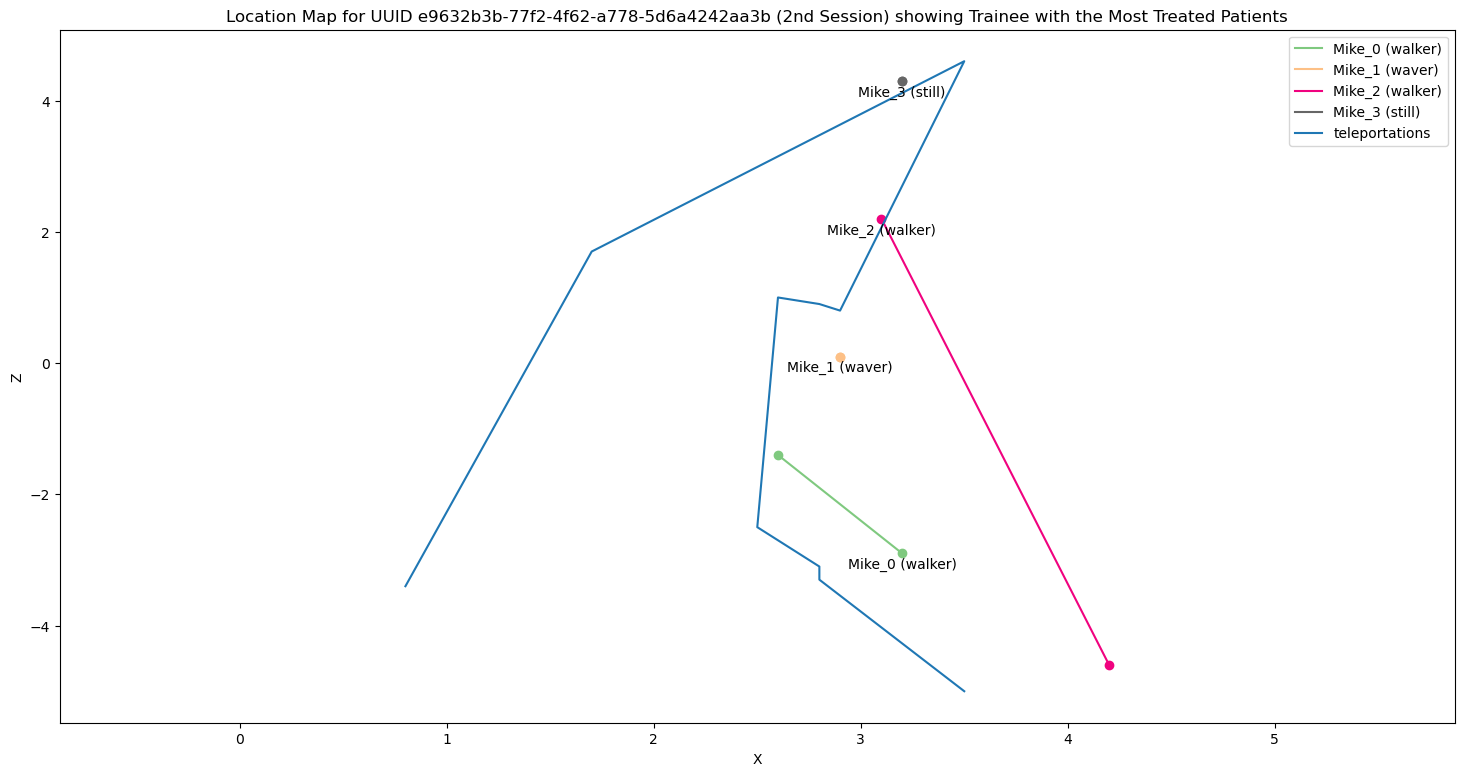

In [10]:

# Get scene with the least ignored patients, v1.0
mask_series = (percentage_treated_df.logger_version == 1.0)
df = percentage_treated_df[mask_series].sort_values(['percentage_treated', 'patients_count']).tail(1)
patients_session_uuid = df.session_uuid.squeeze()
patients_time_group = df.scene_id.squeeze()
base_mask_series = (frvrs_logs_df.session_uuid == patients_session_uuid) & (frvrs_logs_df.scene_id == patients_time_group)

title = f'Location Map for UUID {patients_session_uuid} ({humanize.ordinal(patients_time_group+1)} Session)'
title += ' showing Trainee with the Most Treated Patients'
fu.visualize_player_movement(frvrs_logs_df, base_mask_series, title=title)


## How many patients are treated between walk / wave commands